# Biction price forecasts — based on ARIMA and LSTM model

## 1. Introduction

In our study, we used Auto Regressive Integrated Moving Average (ARIMA) model and Long Short-Term Memory (LSTM) model for BTC price prediction. We would like to know the trend of BTC price in the short term and the performance of price prediction between ARIMA model and LSTM model.

We are interested in time series forecasting because we want to understand the problems we might encounter when using models for practical forecasting. Time series, in general, are difficult to forecast. We know if they were easy to forecast then all data scientists would be wealthy, having accurately forecast the value of all of the stocks. The reality is that hedge funds, on average, do not outperform the market and that time series forecasting is typically very poor and applies only to very short durations. Researchers tell us that the main problems are that there is a lot of noise, there are many hidden influences, models are overly simplistic, influencers do not behave as we think they should, the interplay between linearity and nonlinearity is subtle and confusing. In our study, in addition to predicting BTC price, the most important thing is to better understand the difficulty of time series prediction from practice. 

We chose the data from April 2020 to April 2022, because we know that this period is the new phase of virtual economy like BTC. The global economy has experienced huge change after the COVID-19 outbreak. The real industry suffered a major blow, but both the financial market and the virtual economy have ushered in new growth opportunities after a short period of decline (as shown in the figure below). Therefore, we use the BTC price during this period as our research object.
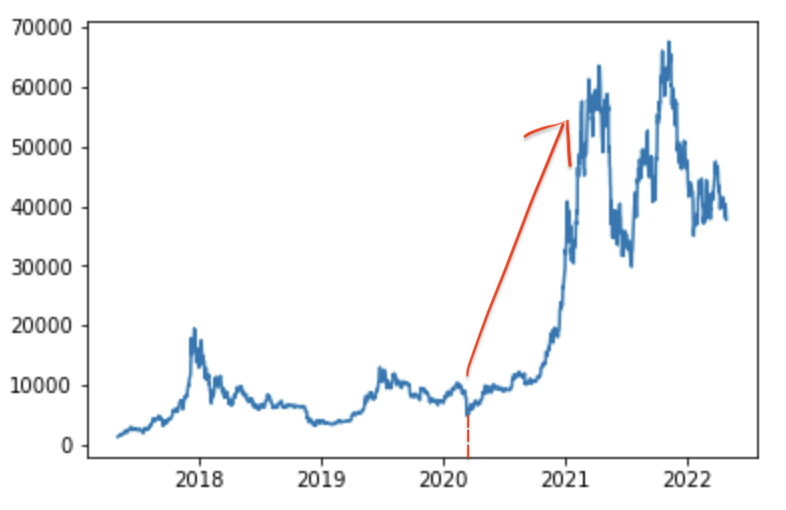

In recent studies, Yamak, Peter, Yujian, Li, Gadosey, Pius(2019) used bitcoin price dataset to compare three different machine learning models in making a time series forecast. The results show that the ARIMA model gave better results than the deep learning-based regression models. What’s more, Ziaul Haque Munim, Mohammad Hassan Shakil and Ilan Alon(2019) analyzes forecasts of Bitcoin price using the autoregressive integrated moving average (ARIMA) and neural network autoregression (NNAR) models. They asserts that despite the sophistication of NNAR, this paper demonstrates ARIMA enduring power of volatile Bitcoin price prediction. Onur Gozbasi, Buket Altinoz , Eyup Ensar Sahin(2021) uses ARDL to explore the impact upon Bitcoin prices of commodities such as gold and oil, the S&P 500 index, and the volatility index and financial stress index, which represent the financial risk environment. Their results shows that increased risk in the long run tend to reduce Bitcoin returns and an index increase pertaining to the US stock market increases Bitcoin prices. Gold prices were found to have no statistically significant effect on the price of Bitcoin, while crude oil prices negatively influence Bitcoin prices in the short run.

## 2. Data

In our study, we collected historical data on BTC prices from **Yahoo Finance** from April 30, 2020 to April 30, 2022.

In [1]:
import yfinance as yf
BTC = yf.download('BTC-USD', start='2020-04-30', end='2022-04-30')
BTC[:5]

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-30,8797.669922,9440.650391,8533.255859,8658.553711,8658.553711,66964629541
2020-05-01,8672.782227,9048.023438,8667.763672,8864.766602,8864.766602,44068389997
2020-05-02,8869.057617,9007.187500,8811.366211,8988.596680,8988.596680,40134388683
2020-05-03,8983.614258,9167.781250,8830.971680,8897.468750,8897.468750,47101785174
2020-05-04,8895.745117,8956.906250,8645.024414,8912.654297,8912.654297,45718796276


We only use one dataset in our study. As can be seen from the figure above, the dataset contains 7 indicators, which are date, day opening price, day high price, day low price, day closing price, adjusted day closing price and day trading volume. We choose to use **daily closing prices** for our forecasts. No missing data or outliers are found in the dataset.

In [2]:
BTC['Close'].describe()

count      731.000000
mean     34723.086588
std      17554.495889
min       8601.795898
25%      13548.505859
50%      38609.824219
75%      47747.423828
max      67566.828125
Name: Close, dtype: float64

Show comprehensive summary statistics as above. We find that our total sample size is 731, the mean value is 34723, and the median is 38609.

## 3. Modeling

In [3]:
def acf_plot(data):
    plot_acf(data)
    plt.title('Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('ACF')

def pacf_plot(data):
    if len(data)<=40:
        plot_pacf(data,lags=(len(data)/2-1))
    else:
        plot_pacf(data)
    plt.title('Partial Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    
def searchARMA(data, exog, max_p, max_q):
    
    aic = np.zeros((max_p,max_q))
    bic = np.zeros((max_p,max_q))
    aic_test = 1000000
    p = 0
    q = 0
    for i in range(max_p):
        for j in range(max_q):
            try:
                if len(exog)==len(data):
                    model = ARMA(data,(i,j),exog=exog)
                else:
                    model = ARMA(data,(i,j))
                res = model.fit(disp=0,trend='nc')
                aic[i,j] = res.aic
                if aic_test>aic[i,j]:
                    aic_test=aic[i,j]
                    p=i
                    q=j
                bic[i,j] = res.bic
                print('p:',i,' q:', j,' aic:', aic[i,j], ' bic:', bic[i,j])
            except:
                continue
    print(p,q)
    
def get_forecast(ARMA_res,log):

    l = len(test)
    start_index = length
    end_index = start_index + l
    f = ARMA_res.predict(start=start_index, end=end_index)
    if log == False:
        forecast = test[0]
        F = [forecast]
        for i in range(1,l):
            forecast = forecast + f[i]
            F.append(forecast)
            i = i+1
    else:
        forecast = np.log(test[0])
        F = [forecast]
        for i in range(1,l):
            forecast = forecast + f[i]
            F.append(forecast)
            i = i+1
            
    return F

def plot_diagnostics(data):
    
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
    ax1.hist(data, bins = 40, color = 'm', density = True)
    mu = data.mean()
    sigma = data.std()
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 2419)
    ax1.plot(x, stats.norm.pdf(x, mu, sigma), linewidth = 5)
    ax1.grid()
    ax1.set_title("Hist Resid")
    
    ax2.plot(data)
    ax2.grid()
    ax2.set_title("Resid")
    
    fig = plot_acf(data,lags=40,zero=False,ax=ax3,use_vlines=True)
    ax3.grid()
    
    fig = sm.qqplot(data, line='q', ax = ax4)
    ax4.grid()
    
    plt.tight_layout()
    
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA, ARMA
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import datetime
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [4]:
BTC_close = np.array(BTC['Close'])
BTC_close.shape

(731,)

### ARIMA model (including first_order difference and log first_order difference)

Text(0, 0.5, 'Close Price USD ($)')

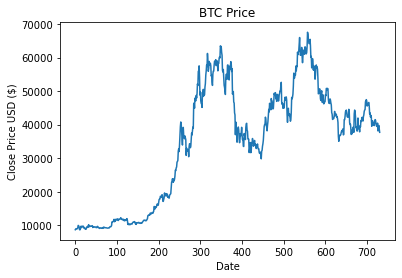

In [5]:
plt.plot(BTC_close)
plt.title('BTC Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

It is obviously that the daily close price times series of BTC presents an increasing trend, so we need to make it stationary. We take the difference of the daily close price and take the difference of the logarithm of the daily close price.

Text(0, 0.5, 'Close Price USD ($)')

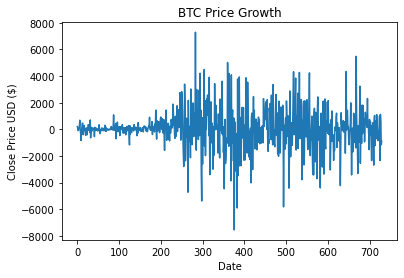

In [6]:
BTC_diff = BTC_close[1:] - BTC_close[:-1]
plt.plot(BTC_diff)
plt.title('BTC Price Growth')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

Text(0, 0.5, 'Close Price USD ($)')

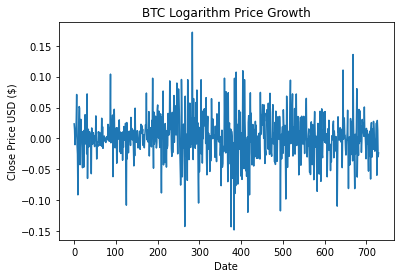

In [7]:
BTC_log = np.log(BTC_close)
BTC_log_diff1 = BTC_log[1:] - BTC_log[:-1]
plt.plot(BTC_log_diff1)
plt.title('BTC Logarithm Price Growth')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')

Both plots above show stationary. Next we take the Augmented Dicky-Fuller test to detect unit roots.

In [8]:
length = int(np.ceil( len(BTC_close)* .9))
train = BTC_close[0:length]
test = BTC_close[length:]
BTC_diff = train[1:] - train[:-1]
BTC_log = np.log(train)
BTC_log_diff = BTC_log[1:] - BTC_log[:-1]

In [9]:
result1 = adfuller(train)
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])
for key, value in result1[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.425670
p-value: 0.569910
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [10]:
result2 = adfuller(BTC_diff)
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
for key, value in result2[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.368992
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [11]:
result3 = adfuller(BTC_log)
print('ADF Statistic: %f' % result3[0])
print('p-value: %f' % result3[1])
for key, value in result3[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.566069
p-value: 0.500612
	1%: -3.440
	5%: -2.866
	10%: -2.569


In [12]:
result4 = adfuller(BTC_log_diff)
print('ADF Statistic: %f' % result4[0])
print('p-value: %f' % result4[1])
for key, value in result4[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.350684
p-value: 0.000000
	1%: -3.440
	5%: -2.866
	10%: -2.569


We can see that only the growing time series and the logarithmic growing time series reject the null hypothesis -the series is non-stationary in the 99% confidence interval. And the autocorrelation plots below also implies that both the first order difference and logarithm of the first order difference show stationary.

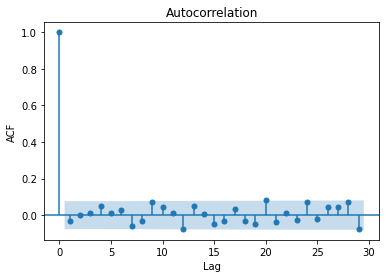

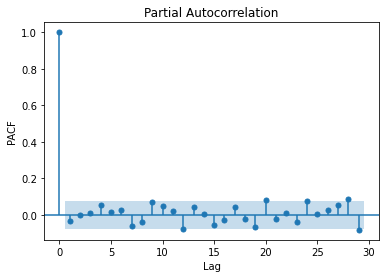

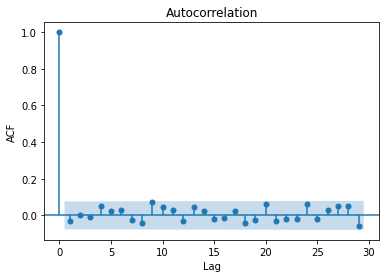

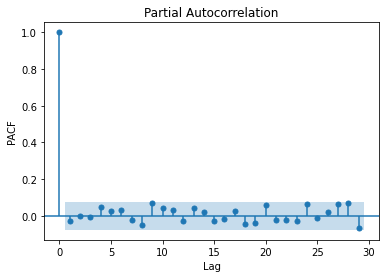

In [13]:
acf_plot(BTC_diff)
pacf_plot(BTC_diff)
acf_plot(BTC_log_diff)
pacf_plot(BTC_log_diff)

### First order difference ARMA model

Besides determining the value of  the degree of differencing by considering the stationary condition of the time series, we use AIC and BIC criterion to select the best AR term and MA term.

In [14]:
n_BTC_diff = len(BTC_diff)
exog_BTC_diff = np.ones(n_BTC_diff)
searchARMA(BTC_diff, exog_BTC_diff, max_p=5, max_q=5)

p: 0  q: 0  aic: 11461.04555903225  bic: 11470.02092706922
p: 0  q: 1  aic: 11462.427075619094  bic: 11475.89012767455
p: 0  q: 2  aic: 11464.420978611135  bic: 11482.371714685074
p: 0  q: 3  aic: 11466.28313214072  bic: 11488.721552233143
p: 0  q: 4  aic: 11466.168699100735  bic: 11493.094803211643
p: 1  q: 0  aic: 11462.424258648192  bic: 11475.887310703647
p: 1  q: 1  aic: 11464.423478097226  bic: 11482.374214171165
p: 1  q: 2  aic: 11465.710367463978  bic: 11488.148787556402
p: 1  q: 3  aic: 11467.311021330112  bic: 11494.237125441019
p: 1  q: 4  aic: 11468.148022956857  bic: 11499.561811086249
p: 2  q: 0  aic: 11464.422961752936  bic: 11482.373697826875
p: 2  q: 1  aic: 11465.685700518976  bic: 11488.1241206114
p: 2  q: 2  aic: 11457.135985076804  bic: 11484.062089187712
p: 2  q: 3  aic: 11456.497805874802  bic: 11487.911594004194
p: 2  q: 4  aic: 11469.980321233697  bic: 11505.881793381574
p: 3  q: 0  aic: 11466.334276952055  bic: 11488.772697044478
p: 3  q: 1  aic: 11467.3960874

In [15]:
model_BTC_diff = ARIMA(BTC_diff,order=(2,0,3))
ARMA_res_1 = model_BTC_diff.fit(disp=0)
print(ARMA_res_1.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  657
Model:                     ARMA(2, 3)   Log Likelihood               -5721.249
Method:                       css-mle   S.D. of innovations           1463.656
Date:                Fri, 06 May 2022   AIC                          11456.498
Time:                        16:17:34   BIC                          11487.912
Sample:                             0   HQIC                         11468.676
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.6729     57.212      0.938      0.348     -58.461     165.807
ar.L1.y       -0.4811      0.021    -22.722      0.000      -0.523      -0.440
ar.L2.y       -0.9573      0.027    -35.805      0.0

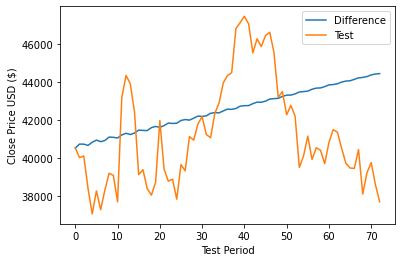

In [16]:
F1 = get_forecast(ARMA_res_1,log=False)
plt.plot(F1)
plt.plot(test)
plt.xlabel('Test Period')
plt.ylabel('Close Price USD ($)')
plt.legend(['Difference','Test'])

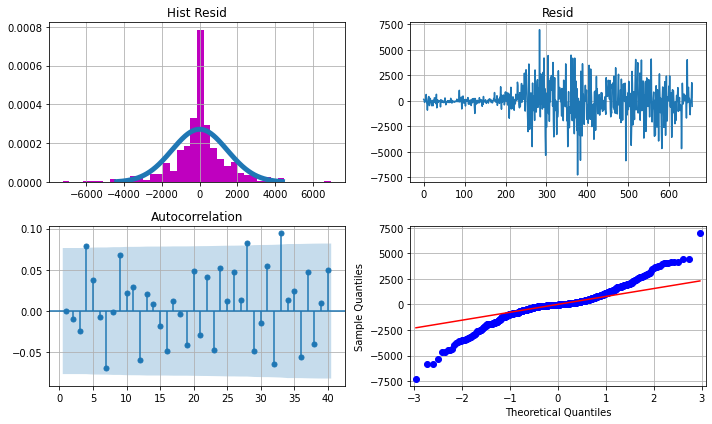

In [17]:
resid_BTC_diff = ARMA_res_1.resid
plot_diagnostics(resid_BTC_diff)

### Logarithm of the first order difference ARIMA model

In [18]:
n_BTC_log_diff = len(BTC_log_diff)
exog_BTC_log_diff = np.ones(n_BTC_log_diff)
searchARMA(BTC_log_diff, exog_BTC_log_diff, max_p=5, max_q=5)

p: 0  q: 0  aic: -2474.5713563911127  bic: -2465.5959883541436
p: 0  q: 1  aic: -2473.153880298363  bic: -2459.6908282429094
p: 0  q: 2  aic: -2471.1556586808665  bic: -2453.204922606928
p: 0  q: 3  aic: -2469.1690745533733  bic: -2446.73065446095
p: 0  q: 4  aic: -2469.1246437915306  bic: -2442.198539680623
p: 1  q: 0  aic: -2473.155535576784  bic: -2459.6924835213304
p: 1  q: 1  aic: -2471.2974438703004  bic: -2453.346707796362
p: 1  q: 2  aic: -2471.0774951614085  bic: -2448.639075068985
p: 1  q: 3  aic: -2469.2213867992623  bic: -2442.2952826883547
p: 1  q: 4  aic: -2467.405512144471  bic: -2435.9917240150785
p: 2  q: 0  aic: -2471.1564162494187  bic: -2453.20568017548
p: 2  q: 1  aic: -2469.323390625281  bic: -2446.8849705328576
p: 2  q: 2  aic: -2467.3470482620432  bic: -2440.4209441511357
p: 2  q: 3  aic: -2471.1223614309165  bic: -2439.708573301524
p: 2  q: 4  aic: -2465.9578818660666  bic: -2430.0564097181896
p: 3  q: 0  aic: -2469.193712132329  bic: -2446.7552920399057
p: 3  

In [19]:
model_BTC_log_diff = ARIMA(BTC_log_diff,order=(0,0,0))
ARMA_res_2 = model_BTC_log_diff.fit(disp=0)
print(ARMA_res_2.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  657
Model:                     ARMA(0, 0)   Log Likelihood                1239.286
Method:                           css   S.D. of innovations              0.037
Date:                Fri, 06 May 2022   AIC                          -2474.571
Time:                        16:17:51   BIC                          -2465.596
Sample:                             0   HQIC                         -2471.092
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.001      1.728      0.084      -0.000       0.005


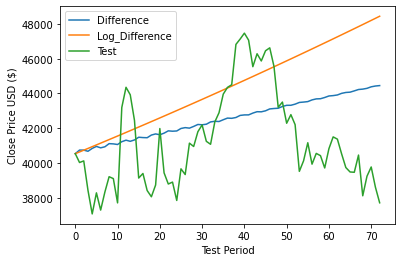

In [20]:
F2 = get_forecast(ARMA_res_2,log=True)
F2 = np.exp(F2)
plt.plot(F1)
plt.plot(F2)
plt.plot(test)
plt.xlabel('Test Period')
plt.ylabel('Close Price USD ($)')
plt.legend(['Difference','Log_Difference','Test'])

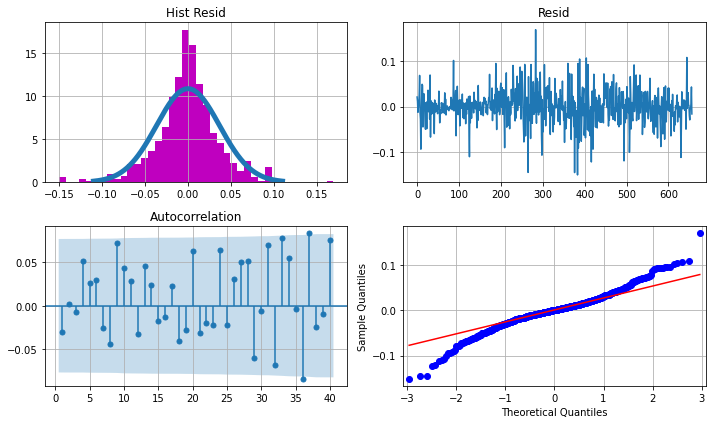

In [21]:
resid_BTC_log_diff = ARMA_res_2.resid
plot_diagnostics(resid_BTC_log_diff)

For the residual plots above, the two density plots in difference order model and logarithm of first order difference model both show uniform distribution. The errors predicted by the two models are stationary. The ACF plots show that most of the residual errors in two model are not autocorrelated. Although we can hardly tell which model performs better since both of them perform similarly, the logarithm of growth still have more accurate performance overall.

### LSTM model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
BTC_LSTM = BTC.filter(['Close'])
dataset = BTC_LSTM.values
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data.shape

(731, 1)

In [23]:
train_data = scaled_data[0:int(length), :]
test_data = scaled_data[int(length)-60: , :]
trainX,trainY=createXY(train_data,60)
testX,testY=createXY(test_data,60)
print(trainX.shape)
print(testX.shape)

(598, 60, 1)
(73, 60, 1)


In [24]:
# Build the LSTM model
BTC_model = Sequential()
BTC_model.add(LSTM(128,return_sequences=True,input_shape=(60,1)))
BTC_model.add(LSTM(64,return_sequences=False))
BTC_model.add(Dense(25))
BTC_model.add(Dense(1))
# Compile the model
BTC_model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
BTC_model.fit(trainX, trainY, batch_size=2, epochs=16)

2022-05-06 16:17:58.001600: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/16
299/299 [==============================] - 9s 22ms/step - loss: 0.0073
Epoch 2/16
299/299 [==============================] - 6s 20ms/step - loss: 0.0031
Epoch 3/16
299/299 [==============================] - 7s 22ms/step - loss: 0.0021
Epoch 4/16
299/299 [==============================] - 7s 22ms/step - loss: 0.0020
Epoch 5/16
299/299 [==============================] - 6s 21ms/step - loss: 0.0014
Epoch 6/16
299/299 [==============================] - 6s 21ms/step - loss: 0.0016
Epoch 7/16
299/299 [==============================] - 7s 22ms/step - loss: 0.0013
Epoch 8/16
299/299 [==============================] - 6s 21ms/step - loss: 0.0015
Epoch 9/16
299/299 [==============================] - 6s 20ms/step - loss: 0.0013
Epoch 10/16
299/299 [==============================] - 6s 20ms/step - loss: 0.0011
Epoch 11/16
299/299 [==============================] - 6s 20ms/step - loss: 0.0012
Epoch 12/16
299/299 [==============================] - 6s 20ms/step - loss: 0.0011
Epoch 13/16
2

In [25]:
predictions = BTC_model.predict(testX)
predictions = scaler.inverse_transform(predictions)
train_LSTM = BTC_LSTM[:length+1]
valid_LSTM = BTC[length:]
valid_LSTM['Predictions'] = predictions
valid_ARIMA = BTC[length:]
valid_ARIMA['Difference'] = F1
valid_ARIMA['Log(Difference)'] = F2

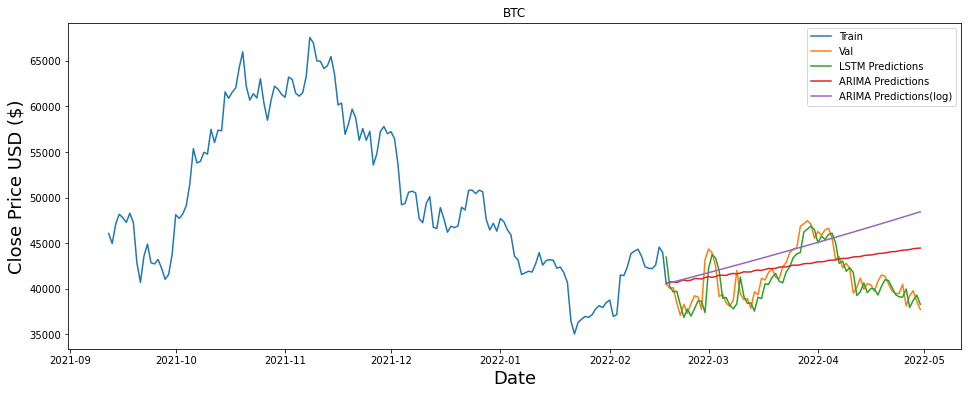

In [26]:
plt.figure(figsize=(16,6))
plt.title('BTC')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_LSTM['Close'][500:])
plt.plot(valid_LSTM[['Close', 'Predictions']])
plt.plot(valid_ARIMA[['Difference', 'Log(Difference)']])
plt.legend(['Train', 'Val', 'LSTM Predictions', 'ARIMA Predictions', 'ARIMA Predictions(log)'], loc='upper right')
plt.show()

It can be seen from the figure that LSTM model can better fit the actual value, while both ARIMA models have certain deviation from the actual value.

### Use LSTM models to predict future prices

In [38]:
train_data = scaled_data
trainX,trainY=createXY(train_data,60)
BTC_model = Sequential()
BTC_model.add(LSTM(128,return_sequences=True,input_shape=(60,1)))
BTC_model.add(LSTM(64,return_sequences=False))
BTC_model.add(Dense(25))
BTC_model.add(Dense(1))
BTC_model.compile(optimizer='adam', loss='mean_squared_error')
BTC_model.fit(trainX, trainY, batch_size=2, epochs=16)

Epoch 1/16
336/336 [==============================] - 12s 28ms/step - loss: 0.0069
Epoch 2/16
336/336 [==============================] - 9s 27ms/step - loss: 0.0031
Epoch 3/16
336/336 [==============================] - 9s 28ms/step - loss: 0.0021
Epoch 4/16
336/336 [==============================] - 9s 28ms/step - loss: 0.0015
Epoch 5/16
336/336 [==============================] - 9s 27ms/step - loss: 0.0013
Epoch 6/16
336/336 [==============================] - 9s 28ms/step - loss: 0.0014
Epoch 7/16
336/336 [==============================] - 9s 26ms/step - loss: 9.9834e-04
Epoch 8/16
336/336 [==============================] - 9s 27ms/step - loss: 0.0012
Epoch 9/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0011
Epoch 10/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0011
Epoch 11/16
336/336 [==============================] - 9s 27ms/step - loss: 0.0013
Epoch 12/16
336/336 [==============================] - 9s 26ms/step - loss: 0.0010
Epoch 13

In [39]:
BTC_60_days_past=BTC.iloc[-60:,:]
last_date = BTC_60_days_past.iloc[[-1]].index
BTC_70_days=BTC_60_days_past

for i in range(10):
    last_date = last_date + timedelta(days=1)
    BTC_70_days= BTC_70_days.append(pd.DataFrame(index=last_date))

BTC_70_days = pd.DataFrame(BTC_70_days['Close'])
BTC_10_days_future = BTC_70_days[-10:]
BTC_60_days_past = pd.DataFrame(BTC_60_days_past['Close'])

old_scaled_array=scaler.transform(BTC_60_days_past)
new_scaled_array=scaler.transform(BTC_10_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

full_df.shape

(70, 1)

In [40]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=60
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step:i,0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=BTC_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

In [41]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,1, axis=-1)
y_pred_future_10_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),1)))[:,0]

In [42]:
BTC_70_days[60:]=pd.DataFrame(y_pred_future_10_days)
print(BTC_70_days)

                   Close
Date                    
2022-03-02  43924.117188
2022-03-03  42451.789062
2022-03-04  39137.605469
2022-03-05  39400.585938
2022-03-06  38419.984375
...                  ...
2022-05-06  38591.937500
2022-05-07  38695.320312
2022-05-08  38798.093750
2022-05-09  38900.367188
2022-05-10  39002.214844

[70 rows x 1 columns]


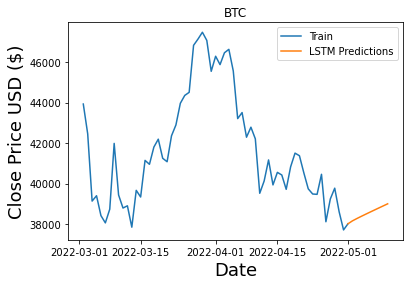

In [43]:
plt.title('BTC')
plt.plot(BTC_70_days[0:61])
plt.plot(BTC_70_days[60:])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend(['Train', 'LSTM Predictions'], loc='upper right')
plt.show()

## 4. Findings

When we used ARIMA and LSTM models to forecast BTC price, we find that BTC price show an upward trend in the short term period. 
Our finding is robust to the first order difference ARIMA model, logarithm of the first order difference ARIMA model and the LSTM model.

## 5. Conclusion

ARIMA model is used to better understand the time series data based on the given values or predict future values in the time series. LSTM model consists of a cell, an input gate, an output gate, and a forget gate. It is a type of Recurrent Neural Network which can classify, process, and provide predictions based on sequences of data. **1.** The two models are used for prediction, but from the fitting effect of test data and predicted values in our study, LSTM model can predict future values more accurately and perform better. **2.** In our study, we also find that compared with ARIMA model, LSTM model is more complex, it takes a long time to run, and there are many input parameters need to tune. **3.** While the LSTM model fits the actual values very well, this is only true if you know the actual values for n days before the expected date. When you want to predict the value of a future day, because the real value is missing in the middle, we can only try to use the value predicted by the model to replace the missing value in the middle, and then we will find that the LSTM model also fails. From above, we ask a question: Is there a better model that can be used for prediction?